In [ ]:
!pip install gymnasium

In [39]:
import gym  # Importing the gym library for game environment
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque  # Importing data collection libraries
from itertools import count  # Importing module for iterating over sequences

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # Importing module for activation functions in PyTorch

env = gym.make("CartPole-v1")  # Creating the game environment "CartPole-v1"

# Setting up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()  # Turning on interactive mode for matplotlib

# Using GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
# Creating a named tuple named 'Transition' with fields 'state', 'action', 'next_state', and 'reward'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        # Initializing memory as a queue with maximum capacity 'capacity'
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Saves a transition to memory"""
        # Adding a new transition to memory, converting arguments into a 'Transition' object
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        # Randomly samples 'batch_size' transitions from memory
        return random.sample(self.memory, batch_size)

    def __len__(self):
        # Returns the current number of elements in memory
        return len(self.memory)


In [41]:
# Definition of the DQN (Deep Q-Network) class representing the neural network model
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        # Linear layer with input size 'n_observations' to 128 neurons
        self.layer1 = nn.Linear(n_observations, 128)
        # Another linear layer from 128 neurons to 128 neurons
        self.layer2 = nn.Linear(128, 128)
        # Linear layer with 128 neurons to 'n_actions' neurons (output)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        # Passing data through layers with ReLU activation function
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        # Returning the result from the last linear layer (without activation function)
        return self.layer3(x)

In [42]:
# Learning hyperparameters and configuration
BATCH_SIZE = 128  # Batch size
GAMMA = 0.99  # Discount factor for future rewards
EPS_START = 0.9  # Initial value of ε (epsilon) in ε-greedy exploration
EPS_END = 0.05  # Final value of ε (epsilon)
EPS_DECAY = 1000  # Decay rate of ε in the exploration process
TAU = 0.005  # Soft target update coefficient for the target model
LR = 1e-4  # Learning rate coefficient

# Getting the number of available actions from the environment's action space
n_actions = env.action_space.n
# Getting the number of state observations
state = env.reset()
n_observations = len(state)

# Initializing the policy_net and target_net models
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

# Initializing the optimizer
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

# Initializing the replay memory
memory = ReplayMemory(10000)

# Initializing the step counter
steps_done = 0

# The select_action function chooses an action in the exploration process
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # Choosing action based on maximum expected reward
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # Random action selection for exploration
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

# List storing episode durations
episode_durations = []

# Function for visualizing the training progress
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())

    # Displaying average episode durations in a window
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # Pause for plots to update
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


In [43]:
# Model optimization by updating neural network weights
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return  # If memory doesn't contain enough transitions, we don't optimize the model

    # Sampling BATCH_SIZE transitions from memory
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Creating a mask for non-final states (whether they are not None)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)

    # Creating a tensor containing states, actions, and rewards from the batch of transitions
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Computing state-action values for states in the batch
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Initializing the next_state_values tensor with zeros
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    # Computing expected state-action values for non-final states
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    # Calculating expected state-action values using the Bellman equation
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Defining the loss function - using the Smooth L1 loss function
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Zeroing gradients, computing gradients, and updating network weights
    optimizer.zero_grad()
    loss.backward()

    # Clipping gradients to avoid gradient explosion
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)

    # Updating network weights based on computed gradients
    optimizer.step()


Completed


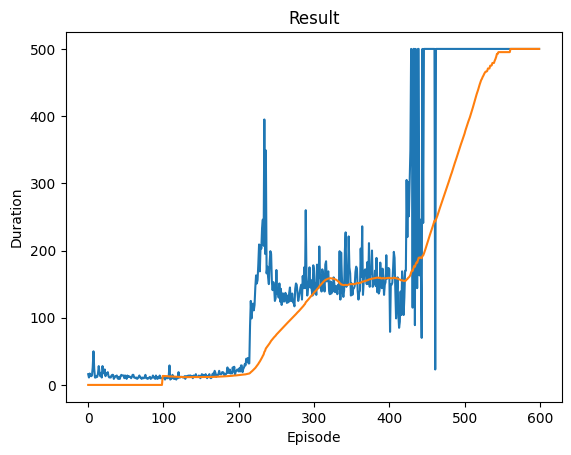

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [44]:
# Checking GPU availability (if available, increase the number of episodes)
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 100

# Main loop - iterates through the specified number of episodes
for i_episode in range(num_episodes):
    # Initializing the environment and getting the initial state
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Saving the transition to the replay memory
        memory.push(state, action, next_state, reward)

        # Moving to the next state
        state = next_state

        # Performing one optimization step (on the policy network)
        optimize_model()

        # Updating target network weights using hard update
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Completed')
plot_durations(show_result=True)
plt.ioff()
plt.show()
